In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics
import gc
from sklearn.ensemble import RandomForestClassifier


# this notebook was helped by https://www.kaggle.com/code/hidetaketakahashi/report-cancerdetection


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cancerdetection-npy/y_train.npy
/kaggle/input/cancerdetection-npy/X_train_s.npy
/kaggle/input/cancerdetection-npy/y_val.npy
/kaggle/input/cancerdetection-npy/X_test.npy
/kaggle/input/cancerdetection-npy/X_val.npy
/kaggle/input/cancerdetection-npy/y_train_s.npy
/kaggle/input/cancerdetection-npy/X_train.npy
/kaggle/input/competition/sample_submission.csv/sample_submission.csv
/kaggle/input/competition/train_labels.csv/train_labels.csv


### Cancer Detection: Kaggle Mini Project

## Read in our data and use two separate sources, as the npy file is smaller and takes less time to read in than the original dataset.

In [90]:
# Kaggle original dataset

data_samples = '/kaggle/input/competition/sample_submission.csv'
data_label = '/kaggle/input/competition/train_labels.csv/train_labels.csv'

In [91]:
#load the files


labels_df = pd.read_csv(data_label)


## With the amount of information in the original dataset, it was taking a long time to load. Another dataset that was stored in a npy was easier to work with and processed faster 

In [92]:
# npy data

fpath = "/kaggle/input/cancerdetection-npy/X_test.npy"

X_test = np.load(fpath)

In [93]:
# npy data
fpath = "/kaggle/input/cancerdetection-npy/X_val.npy"
X_value = np.load(fpath)

fpath = "/kaggle/input/cancerdetection-npy/y_val.npy"
y_value = np.load(fpath)

In [94]:
# we will need to restrict the train number due to memory capabilities

fpath = "/kaggle/input/cancerdetection-npy/X_train.npy"
X_train = np.load(fpath)[0:40000]

fpath = "/kaggle/input/cancerdetection-npy/y_train.npy"
y_train = np.load(fpath)[0:40000]

## We will next train the model, then begin to do more EDA 

In [95]:
X_train.shape, X_value.shape, y_train.shape, y_value.shape, X_test.shape

((40000, 96, 96, 3),
 (10000, 96, 96, 3),
 (40000, 1),
 (10000, 1),
 (57458, 96, 96, 3))

In [96]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_value = X_value.shape[0]

## If we can identify certain colors in the images that indicate cancer, we can use the images for predictions based on their colors.

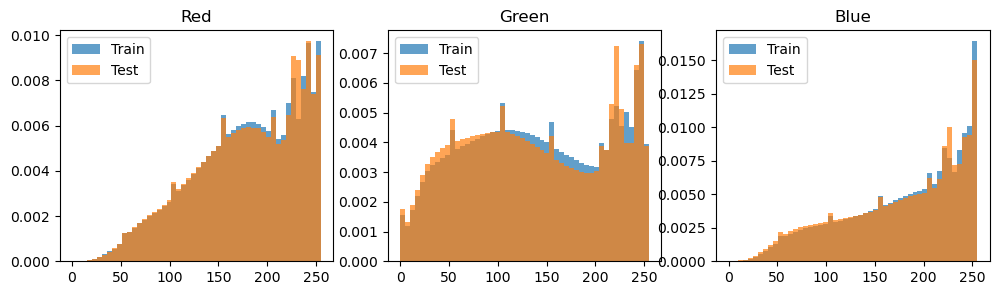

In [107]:
np.random.seed(1)
sample_train = np.random.choice(n_train, 4000)
sample_test = np.random.choice(n_test, 4000)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))

titles = ["Red", "Green", "Blue"]
for i in range(3):
    ax[i].hist(X_train[sample_train, :, :, i].flatten(), density = True, alpha = 0.7, bins = 50, label = "Train")
    ax[i].hist(X_test[sample_test, :, :, i].flatten(), density = True, alpha = 0.7, bins = 50, label = "Test")
    
    ax[i].set_title(titles[i])
    ax[i].legend()

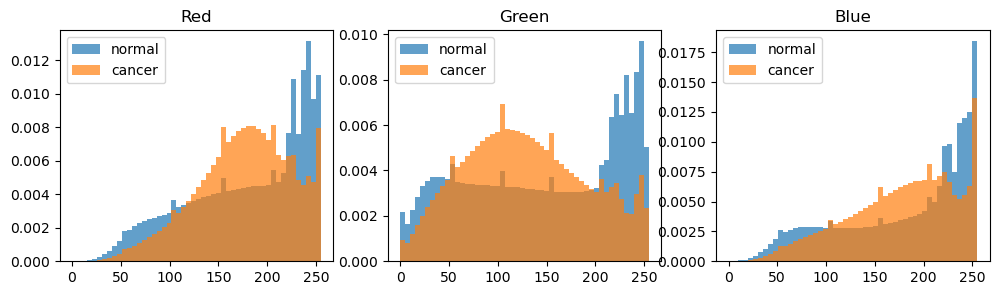

In [98]:
sample_positive = y_value.flatten() == 1
sample_negative = y_value.flatten() == 0

fig, ax = plt.subplots(1, 3, figsize = (12, 3))

titles = ["Red", "Green", "Blue"]
for i in range(3):
    ax[i].hist(X_value[sample_negative, :,:,i].flatten(), density = True, alpha = 0.7, bins = 50, label = "normal")
    ax[i].hist(X_value[sample_positive, :,:,i].flatten(), density = True, alpha = 0.7, bins = 50, label = "cancer")
    ax[i].set_title(titles[i])
    ax[i].legend()

## Next we will look at the comparison of postive and negative cancer images 

In [99]:
def plot_photo(X):
    
    N = X.shape[0]
    nc = 10
    nr = math.ceil(N/nc)
    
    fig, ax = plt.subplots(nr, nc, figsize = (14, nr*1.4))
    
    for k in range(N):
        i =  int(k/nc)
        j = k % nc
        ax[i,j].imshow(X[k])
        ax[i,j].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

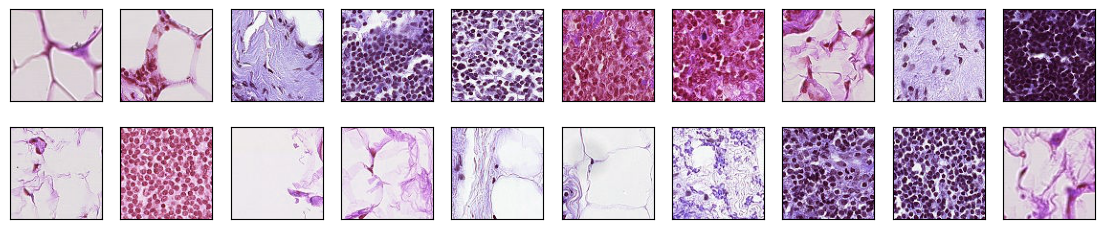

In [100]:
plot_photo(X_value[sample_negative][0:20])

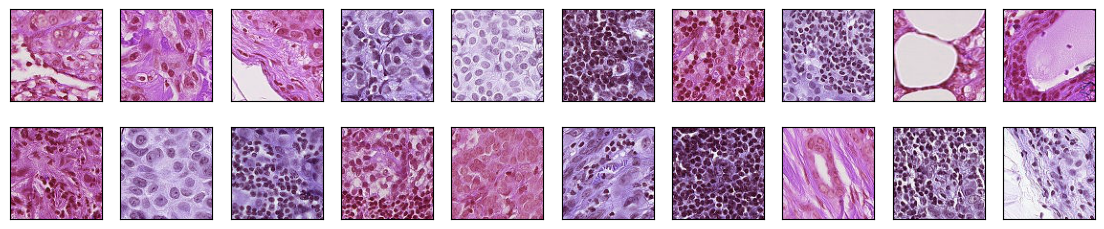

In [101]:
plot_photo(X_value[sample_positive][0:20])

## Let us now use our EDA to make a prediction on the images. We can use the red, green, and blue values from our EDA to make a classifier for the images using a RandomForest Classifier

In [102]:
# Calculation of mean RGB
Z_train = np.zeros((n_train, 3))
Z_value = np.zeros((n_value, 3))
Z_test = np.zeros((n_test, 3))

for j in range(3):

    for i in range(n_train):
        Z_train[i,j] = np.mean(X_train[i,:,:,j])

    for i in range(n_value):
        Z_value[i,j] = np.mean(X_value[i,:,:,j])

    for i in range(n_test):
        Z_test[i,j] = np.mean(X_test[i,:,:,j])

In [110]:
#intialize the classifier 

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(Z_train, y_train.flatten())


RandomForestClassifier(max_depth=10, random_state=0)

In [111]:
yhat_train = clf.predict_proba(Z_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat_train[:,1], pos_label=1)
train_auc = metrics.auc(fpr, tpr)

yhat_value = clf.predict_proba(Z_value)
fpr, tpr, thresholds = metrics.roc_curve(y_value, yhat_value[:,1], pos_label=1)
val_auc = metrics.auc(fpr, tpr)

print("train auc", np.round(train_auc, 3))
print("validation auc", np.round(val_auc, 3))

train auc 0.872
validation auc 0.845


In [113]:
#intialize the classifier 

clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(Z_train, y_train.flatten())


RandomForestClassifier(max_depth=20, random_state=0)

In [114]:
yhat_train = clf.predict_proba(Z_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat_train[:,1], pos_label=1)
train_auc = metrics.auc(fpr, tpr)

yhat_value = clf.predict_proba(Z_value)
fpr, tpr, thresholds = metrics.roc_curve(y_value, yhat_value[:,1], pos_label=1)
val_auc = metrics.auc(fpr, tpr)

print("train auc", np.round(train_auc, 3))
print("validation auc", np.round(val_auc, 3))

train auc 0.993
validation auc 0.867


### In conclusion, we could find a more accurate way to do this. You could also use binary classification and see if that would give improved accuracy. When you increase max depth from 10 to 20, you increase accuracy as shown above. 